# SNIP Fit Analysis
**In this notebook, we analyze the fits computed from Pymca's SNIP tool. We analyze the fits using various SNIP widths to see which width allows for the diffraction peaks to be snipped out in the cleanest manner while preserving the principal Hf counts. We examine data from the chip rotated at 40 degrees because we observed qualitatively that this angle may allow for the best separation of the fluorescence and diffraction peaks.**

*Date: 07/11/2024*

*Author: Sonia Ghoshal, NIST SURF*

## 1.1 Setup
### Chip Details:
* type: KRISS K157 #502
* thicknesses: 6.0nm, 3.0nm, 2.0nm HfO2
* composition: HfO2 nanofilm over Si substrate
### Experiment summary: 
* initially took mXRF scans at rotations of angles 0, 10, 20, 30, 40, 50, 60, 70, 80, 90
* each measurement consisted of 10 Detector 1 (D1) scans and 10 Detector 2 (D2) scans
* observed that angle 40 and D1 scans allowed for the best isolation of Hf peaks
* took measurements at angles 32, 34, 36, 38, 40, 42, 44, 46, 48
* angle 40 once again seemed to be the best angle
* Here, we use the 9th D1 scan (D1_8) for consistency, but eventually we want to average all of the D1 scans at angle 40
* path to data: C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\data\raw\20240626_K157_6nm_Rotation\40_deg\20240626_K157_6nm_Rotation_40_deg_repeat_Rh_FE_D1_0_8.spx

## 1.2 Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import glob
import os

## 1.3 .fit File Reading

In [2]:
def readFitFile(path):
    fit = open(path)

    #ignore the [info] section. We only care about [results] section
    line = fit.readline()
    while("result") not in line:
       line = fit.readline()

    # there is a space between every number, so we split up the array by spaces
    # by doing so, we have unwanted items "xdata', "=", and "[ " in the array, which we exclude by starting at index 3
    xdata = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    energy = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    ydata = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    yfit = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    continuum = np.array(fit.readline().split(" ")[3:-1], dtype=float)

    fit.close()
    
    return xdata, energy, ydata, yfit, continuum

In [21]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\K157_Rotation_40_D1_Fit1\\")
data = {}
for i in ["5", "10", "20", "30", "45", "60"]:
    data[i] = readFitFile(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])

#data


In [17]:
# WORK IN PROGRESS FOR MULTIPLE THICKNESSES

# os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\K157_Rotation_40_D1_Fit1\\")
# data = {}
# for j in ["6.0", "3.0", "2.0"]:
#     data[j] = {}
# for i in ["5", "10", "20", "30", "45", "60"]:
#      data["6.0"][i] = readFitFile(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])
# #     data["3.0"][i] = readFitFile(glob.glob("20240626_K157_3nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])
# #     data["2.0"][i] = readFitFile(glob.glob("20240626_K157_2nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])

# data

{'6.0': {'5': (array([  69.,   70.,   71., ..., 2698., 2699., 2700.]),
   array([-0.2244841 , -0.21472316, -0.20496221, ..., 25.43703244,
          25.44679338, 25.45655432]),
   array([ 1.,  2.,  2., ...,  7.,  8., 11.]),
   array([ 2.18364385,  2.12387191,  2.06362   , ..., 10.84299713,
          12.15468182, 13.46721042]),
   array([ 2.18364385,  2.12387191,  2.06362   , ..., 10.84299713,
          12.15468182, 13.46721042])),
  '10': (array([  69.,   70.,   71., ..., 2698., 2699., 2700.]),
   array([-0.2752706 , -0.26526423, -0.25525785, ..., 26.03149737,
          26.04150375, 26.05151013]),
   array([ 1.,  2.,  2., ...,  7.,  8., 11.]),
   array([ 0.95633497,  0.91718649,  0.87729941, ...,  9.33677442,
          10.59207446, 11.84744388]),
   array([ 0.95633497,  0.91718649,  0.87729941, ...,  9.33677442,
          10.59207446, 11.84744388])),
  '20': (array([  69.,   70.,   71., ..., 2698., 2699., 2700.]),
   array([-0.27328474, -0.26328346, -0.25328219, ..., 26.02006139,
      

**Summary:**
Now, we have collected the data from the .fit file and arranged it in a 4D array. The first index (String type) corresponds to the thickness, the second index (String type) corresponds to the SNIP width (5, 10, 20, 30, 45, or 60) and the third index (float type) corresponds to the type of data (xdata, energy, ydata, yfit, or continuum). 

`data['thickness']['width'][0]` gives an array of xdata (channels) 

`data['thickness']['width'][1]` gives an array of energy

`data['thickness']['width'][2]` gives an array of ydata coordinates

`data['thickness']['width'][3]` gives an array of yfit coordinates

`data['thickness']['width'][4]` gives an array of continuum (y-coordinates)


## 1.4 Plotting the Fits

In [18]:
# Establishing the "viridis" colormap for data visuals
cmap = plt.colormaps.get_cmap('viridis')

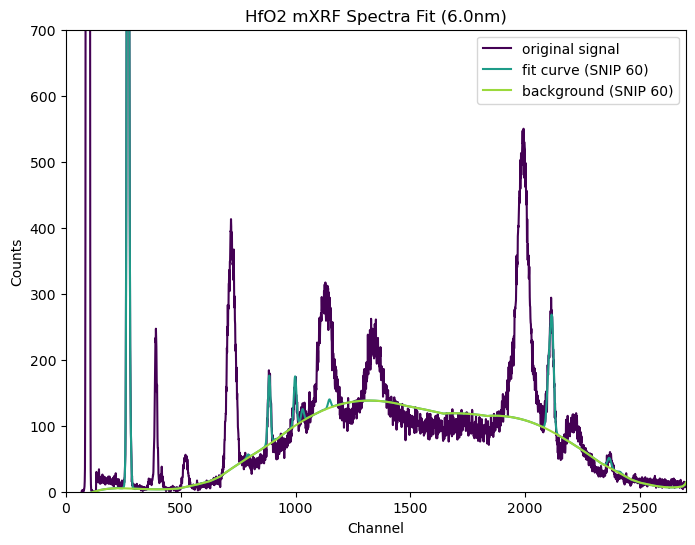

In [22]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 0, xmax = 2700)
ax.set_ylim(ymin = 0, ymax = 700)

ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["60"][0], data["60"][3], color = cmap(0.55), label = "fit curve (SNIP 60)" )
ax.plot(data["60"][0],data["60"][4], color = cmap(0.85), label = "background (SNIP 60)")

ax.legend()
ax.set_title("HfO2 mXRF Spectra Fit (6.0nm)")
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")

os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
plt.savefig("HfO2_Spectra_SNIP60_40deg")

plt.show()

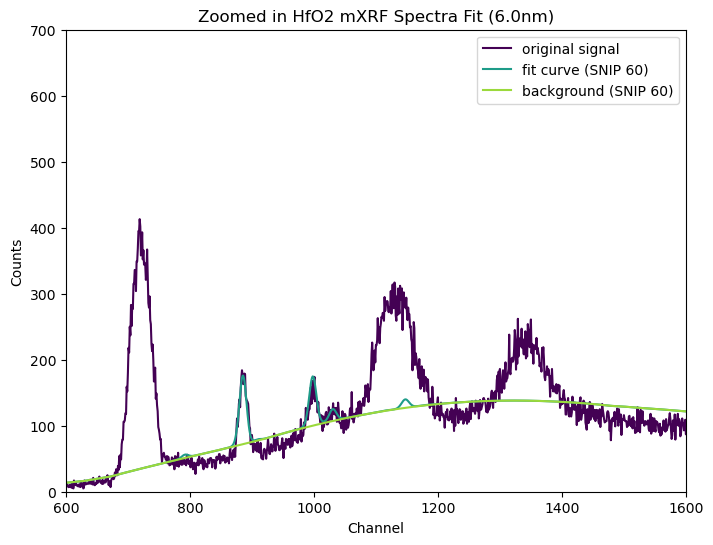

In [26]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 700)

ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["60"][0], data["60"][3], color = cmap(0.55), label = "fit curve (SNIP 60)" )
#ax.plot(data["30"][0], data["30"][3], color = 'r', label = "fit curve (SNIP 30)" )
#ax.plot(data["20"][0], data["20"][3], color = 'b', label = "fit curve (SNIP 20)" )
ax.plot(data["60"][0],data["60"][4], color = cmap(0.85), label = "background (SNIP 60)")

ax.legend()
ax.set_title("Zoomed in HfO2 mXRF Spectra Fit (6.0nm)")
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")

#os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
#plt.savefig("Zoom_HfO2_Spectra_SNIP60_40deg")

plt.show()

## 1.5 Isolating the peaks 
#### Here, we subtract the continuum from the signal in an effort to isolate the fluorescence peaks.

In [13]:
# returns an array of the spectra counts - continuum counts
# parameters: arr1 is the spectra counts (ydata), arr2 is the continuum
def cleanedSignal(arr1, arr2): 
    if(len(arr1) != len(arr2)): 
        raise ValueError("Arrays must be same length.")
    
    subtractbg = [0] * len(arr1)
    for i in range(len(arr1)): 
         subtractbg[i] = arr1[i] - arr2[i]

    return subtractbg

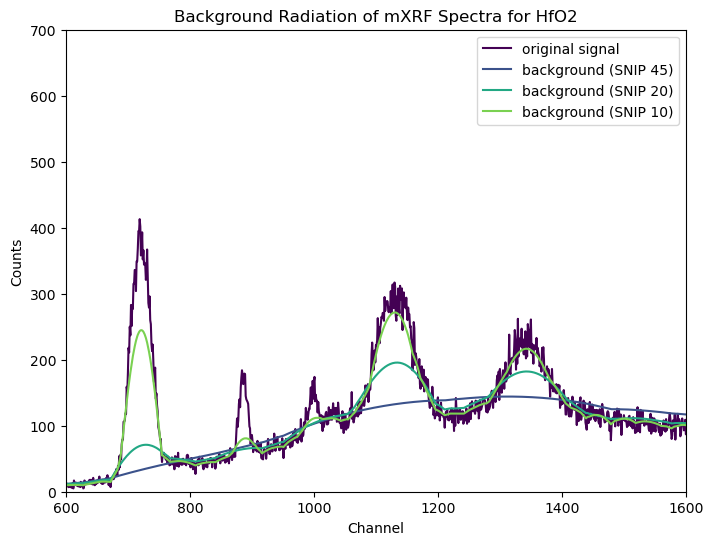

In [14]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 700)
ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["45"][0],data["45"][4], color = cmap(0.25), label = "background (SNIP 45)")
#ax.plot(data["30"][0],data["30"][4], color = cmap(0.4), label = "background (SNIP 30)")
ax.plot(data["20"][0],data["20"][4], color = cmap(0.6), label = "background (SNIP 20)")
ax.plot(data["10"][0],data["10"][4], color = cmap(0.8), label = "background (SNIP 10)")
ax.legend()
ax.set_ylabel("Counts")
ax.set_xlabel("Channel")
ax.set_title("Background Radiation of mXRF Spectra for HfO2")

os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
plt.savefig("Bg_HfO2_Spectra_SNIPs_40deg")
plt.show()

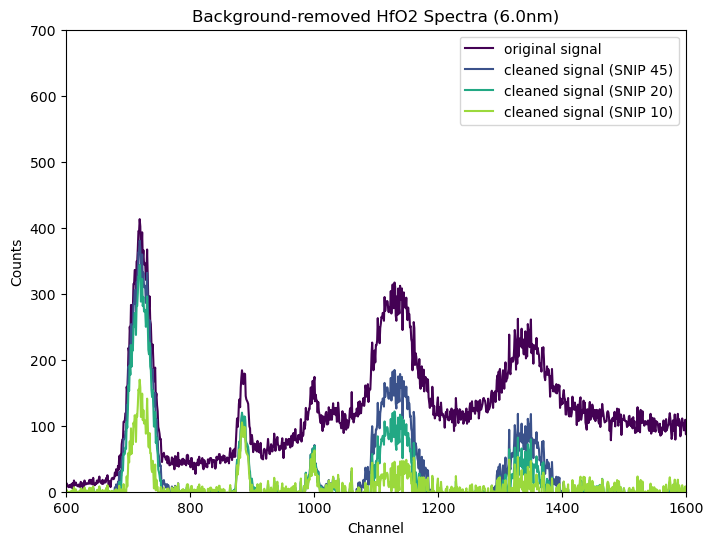

In [64]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 700)

ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["45"][0], cleanedSignal(data["45"][2], data["45"][4]), color = cmap(0.25), label = "cleaned signal (SNIP 45)")
#ax.plot(data["30"][0], cleanedSignal(data["30"][2], data["30"][4]), color = cmap(0.5), label = "cleaned signal (SNIP 30)")
ax.plot(data["20"][0], cleanedSignal(data["20"][2], data["20"][4]), color = cmap(0.6), label = "cleaned signal (SNIP 20)")
ax.plot(data["10"][0], cleanedSignal(data["10"][2], data["10"][4]), color = cmap(0.85), label = "cleaned signal (SNIP 10)")

ax.legend()
ax.set_ylabel("Counts")
ax.set_xlabel("Channel")
ax.set_title("Background-removed HfO2 Spectra (6.0nm)")

os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
plt.savefig("Noise_removed_HfO2_Spectra_SNIPs_40deg")

plt.show()

## 2.1 Determining Principal Peak Counts
**In this section, we use the .fit file data to calculate the area under the curve of the principal peaks of Hf (L1, L2, and L3). We calculate this area for the original spectra and all of the "cleaned" spectra with varying SNIP widths. We undergo these calculations for wafers of different thicknesses (6.0nm, 3.0nm, 2.0nm), and observe whether the calculated principal peak counts are proportional to the thicknesses of the wafers. This will allow us to determine which SNIP widths retain accurate peak counts.**

In [28]:
def readPeakCounts(path): 
    fit = open(path)
    
    #ignore the [info] section. We only care about [results] section
    line = fit.readline()
    while("yHf L") not in line:
        line = fit.readline()
    # there is a space between every number, so we split up the array by spaces
    # by doing so, we have unwanted items "yHf", "L", "=", and "[" in the array, which we exclude by starting at index 4
    yHf_L = np.array(line.split(" ")[4:-1], dtype=float)
    yHf_L1 = np.array(fit.readline().split(" ")[4:-1], dtype=float)
    yHf_L2 = np.array(fit.readline().split(" ")[4:-1], dtype=float)
    yHf_L3 = np.array(fit.readline().split(" ")[4:-1], dtype=float)

    fit.close()
    
    return yHf_L, yHf_L1, yHf_L2, yHf_L3
    

In [65]:
#Determine which angle has the highest counts of Hf (SNIP 60 for all)
# compare counts for 2nm, 3nm, and 6nm: which angle provides for the most accurate ratios of counts? (2:3:6)
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\all_60_fits\\")
peaks_2nm_36D1_L3 = readPeakCounts(glob.glob("20240723_K157_2nm_Rotation_36_deg_repeat_Rh_FE_D1_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_2nm_36D2_L3 = readPeakCounts(glob.glob("20240723_K157_2nm_Rotation_36_deg_repeat_Rh_FE_D2_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_2nm_40D2_L3 = readPeakCounts(glob.glob("20240723_K157_2nm_Rotation_40_deg_repeat_Rh_FE_D2_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_2nm_40D1_L3 = readPeakCounts(glob.glob("20240723_K157_2nm_Rotation_40_deg_repeat_Rh_FE_D1_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_2nm_42D2_L3 = readPeakCounts(glob.glob("20240723_K157_2nm_Rotation_42_deg_repeat_Rh_FE_D2_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_2nm_48D2_L3 = readPeakCounts(glob.glob("20240723_K157_2nm_Rotation_48_deg_repeat_Rh_FE_D2_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_3nm_36D1_L3 = readPeakCounts(glob.glob("20240722_K157_3nm_Rotation_36_deg_repeat_Rh_FE_D1_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_3nm_36D2_L3 = readPeakCounts(glob.glob("20240722_K157_3nm_Rotation_36_deg_repeat_Rh_FE_D2_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_3nm_38D1_L3 = readPeakCounts(glob.glob("20240722_K157_3nm_Rotation_38_deg_repeat_Rh_FE_D1_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_3nm_38D2_L3 = readPeakCounts(glob.glob("20240722_K157_3nm_Rotation_38_deg_repeat_Rh_FE_D2_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_3nm_40D1_L3 = readPeakCounts(glob.glob("20240722_K157_3nm_Rotation_40_deg_repeat_Rh_FE_D1_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_3nm_44D1_L3 = readPeakCounts(glob.glob("20240722_K157_3nm_Rotation_44_deg_repeat_Rh_FE_D1_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_6nm_36D1_L3 = readPeakCounts(glob.glob("20240702_K157_6nm_Rotation_36_deg_repeat_Rh_FE_D1_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_6nm_36D2_L3 = readPeakCounts(glob.glob("20240702_K157_6nm_Rotation_36_deg_repeat_Rh_FE_D2_0_8.spx_1.1.1.1.fit")[0])[2]
peaks_6nm_40D1_L3 = readPeakCounts(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_60SNIP.fit")[0])[2]

counts_60data = {'36deg D1': [peaks_2nm_36D1_L3.sum(), peaks_3nm_36D1_L3.sum(), peaks_6nm_36D1_L3.sum()], 
               '36deg D2': [peaks_2nm_36D2_L3.sum(), peaks_3nm_36D2_L3.sum(), peaks_6nm_36D2_L3.sum()],
               '38deg D1': [0, peaks_3nm_38D1_L3.sum(), 0],
               '38deg D2': [0, peaks_3nm_38D2_L3.sum(), 0],
               '40deg D1': [peaks_2nm_40D1_L3.sum(), peaks_3nm_40D1_L3.sum(), peaks_6nm_40D1_L3.sum()], 
               '40deg D2': [peaks_2nm_40D2_L3.sum(), 0, 0],
               '42deg D2': [peaks_2nm_42D2_L3.sum(), 0, 0], 
               '44deg D1': [0, peaks_3nm_44D1_L3.sum(), 0],
               '48deg D2': [peaks_2nm_48D2_L3.sum(), 0, 0]
              }
counts_60 = pd.DataFrame(data = counts_60data, index = ['2nm', '3nm', '6nm'])
counts_60

,36deg D1,36deg D2,38deg D1,38deg D2,40deg D1,40deg D2,42deg D2,44deg D1,48deg D2
2nm,595.355794,5.856688,0.000000,0.000000,356.611795,395.395655,295.925301,0.000000,601.717533
3nm,977.589327,634.422771,638.721606,476.044957,568.803496,0.000000,0.000000,823.155714,0.000000
6nm,1098.840366,1098.883992,0.000000,0.000000,1291.367755,0.000000,0.000000,0.000000,0.000000


Notes: 

36deg D2 for 2nm is an outlier. Pymca not accurately fitting 


In [19]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\K157_Rotation_40_D1_Fit1\\")
data_peaks = {}
for i in ["5", "10", "20", "30", "45", "60"]:
    data_peaks[i] = readPeakCounts(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])

In [ ]:
# WORK IN PROGRESS FOR MULTIPLE FILES
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\")
data_peaks = {}
for j in [0, 1, 2]:
    for i in ["5", "10", "20", "30", "45", "60"]:
        data_peaks[j][i] = readPeakCounts(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])

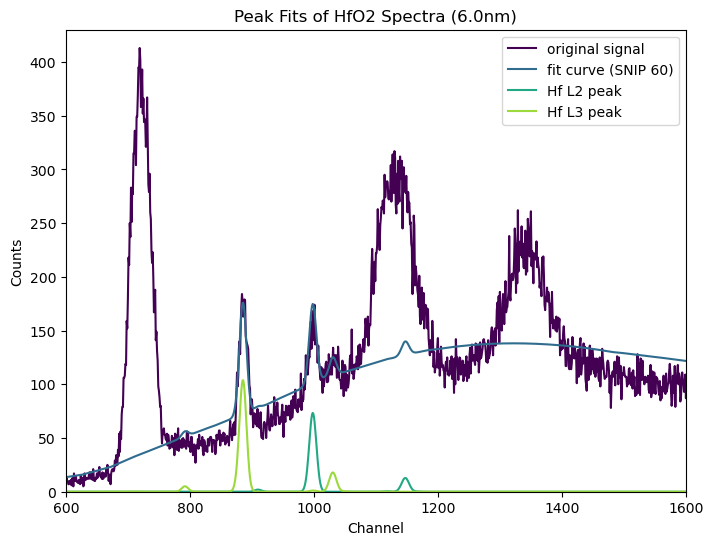

In [54]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 430)
ax.set_title("Peak Fits of HfO2 Spectra (6.0nm)")
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")
ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["60"][0], data["60"][3], color = cmap(0.35), label = "fit curve (SNIP 60)")
#ax.plot(data["60"][0], data_peaks["60"][0], color = cmap(, label= "yHf L peaks")
#ax.plot(data["60"][0], data_peaks["60"][1], color = 'g', label= "yHf L1 peaks")
ax.plot(data["60"][0], data_peaks["60"][2], color = cmap(0.6), label= "Hf L2 peak")
ax.plot(data["60"][0], data_peaks["60"][3], color = cmap(0.85), label= "Hf L3 peak")
ax.legend()

os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
plt.savefig("Peak_Fits_HfO2_6nm_Rot40_SNIP60")


plt.show()

In [42]:
#MAKE 3 arrays/lists for each thickness. Each array will have 5 indices for the 5 SNIPS, giving the sum of L3
#create a DF from these 3 lists 

# peakL3_sums = {}
# for i in ["5", "10", "20", "30", "45", "60"]:
#     peakL3_sums[i] = data_peaks[i][3].sum()

# peak_sums = {}
# for i in ["5", "10", "20", "30", "45", "60"]:
#     for j in range(3):
#         peak_sums[i][j] = data_peaks[i][j+1].sum()

# test = {'5': [1, 2, 3], 
#         '10': [4, 5, 6]}
# testdf = pd.DataFrame(data = test, index = ['test1', 'test2', 'test3'])
# testdf
#peakL3_df = pd.DataFrame(data = peakL3_sums, index = ['6.0.nm', '3.0nm', '2.0nm'])
#peakL3_df

,5,10
test1,1,4
test2,2,5
test3,3,6
